# Method 6 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

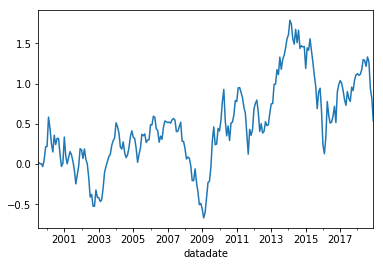

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.213980
2000-12-31   -0.169420
2001-12-31    0.181479
2002-12-31   -0.507927
2003-12-31    1.256604
2004-12-31    0.068330
2005-12-31   -0.077846
2006-12-31    0.169946
2007-12-31   -0.159931
2008-12-31   -0.600677
2009-12-31    1.822378
2010-12-31    0.239321
2011-12-31   -0.199950
2012-12-31    0.139434
2013-12-31    0.567588
2014-12-31   -0.037728
2015-12-31   -0.325476
2016-12-31    0.197088
2017-12-31    0.060801
2018-12-31   -0.270416
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     219.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.04e-77
Time:                        14:40:05   Log-Likelihood:                 351.84
No. Observations:                 234   AIC:                            -693.7
Df Residuals:                     229   BIC:                            -676.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.004      0.850      0.396      -0.004       0.010
mktrf          1.3891      0.101     13.696      0.000       1.189       1.589
me             0.9456      0.118      8.014      0.000       0.713       1.178
ia             0.7189      0.179      4.009      0.000       0.366       1.072
roe           -1.4530      0.153     -9.466      0.000      -1.755      -1.151
==============================================================================
Omnibus:                       72.513   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.273
Skew:                           1.329   Prob(JB):                     2.96e-47
Kurtosis:                       6.862   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     85.15
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.38e-44
Time:                        14:40:05   Log-Likelihood:                 351.84
No. Observations:                 234   AIC:                            -693.7
Df Residuals:                     229   BIC:                            -676.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.004      0.890      0.373      -0.004       0.010
mktrf          1.3891      0.128     10.839      0.000       1.138       1.640
me             0.9456      0.114      8.297      0.000       0.722       1.169
ia             0.7189      0.191      3.757      0.000       0.344       1.094
roe           -1.4530      0.266     -5.458      0.000      -1.975      -0.931
==============================================================================
Omnibus:                       72.513   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.273
Skew:                           1.329   Prob(JB):                     2.96e-47
Kurtosis:                       6.862   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     100.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.66e-49
Time:                        14:40:05   Log-Likelihood:                 351.84
No. Observations:                 234   AIC:                            -693.7
Df Residuals:                     229   BIC:                            -676.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.004      0.887      0.375      -0.004       0.010
mktrf          1.3891      0.109     12.734      0.000       1.175       1.603
me             0.9456      0.127      7.425      0.000       0.696       1.195
ia             0.7189      0.182      3.954      0.000       0.363       1.075
roe           -1.4530      0.260     -5.598      0.000      -1.962      -0.944
==============================================================================
Omnibus:                       72.513   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.273
Skew:                           1.329   Prob(JB):                     2.96e-47
Kurtosis:                       6.862   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     151.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.41e-70
Time:                        14:40:05   Log-Likelihood:                 338.84
No. Observations:                 234   AIC:                            -665.7
Df Residuals:                     228   BIC:                            -644.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.004      0.316      0.752      -0.007       0.009
mktrf          1.5523      0.108     14.417      0.000       1.340       1.764
smb            1.0540      0.142      7.420      0.000       0.774       1.334
hml            0.7498      0.168      4.476      0.000       0.420       1.080
rmw           -1.1301      0.189     -5.967      0.000      -1.503      -0.757
cma            0.1480      0.241      0.615      0.539      -0.326       0.622
==============================================================================
Omnibus:                       91.201   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.876
Skew:                           1.614   Prob(JB):                     6.35e-72
Kurtosis:                       7.818   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     114.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.25e-60
Time:                        14:40:05   Log-Likelihood:                 338.84
No. Observations:                 234   AIC:                            -665.7
Df Residuals:                     228   BIC:                            -644.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.004      0.287      0.774      -0.007       0.010
mktrf          1.5523      0.097     15.956      0.000       1.362       1.743
smb            1.0540      0.134      7.860      0.000       0.791       1.317
hml            0.7498      0.233      3.218      0.001       0.293       1.206
rmw           -1.1301      0.248     -4.551      0.000      -1.617      -0.643
cma            0.1480      0.322      0.459      0.646      -0.483       0.779
==============================================================================
Omnibus:                       91.201   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.876
Skew:                           1.614   Prob(JB):                     6.35e-72
Kurtosis:                       7.818   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     123.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-62
Time:                        14:40:05   Log-Likelihood:                 338.84
No. Observations:                 234   AIC:                            -665.7
Df Residuals:                     228   BIC:                            -644.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.005      0.271      0.786      -0.008       0.010
mktrf          1.5523      0.083     18.631      0.000       1.389       1.716
smb            1.0540      0.130      8.084      0.000       0.799       1.310
hml            0.7498      0.188      3.992      0.000       0.382       1.118
rmw           -1.1301      0.245     -4.608      0.000      -1.611      -0.649
cma            0.1480      0.314      0.471      0.638      -0.468       0.764
==============================================================================
Omnibus:                       91.201   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.876
Skew:                           1.614   Prob(JB):                     6.35e-72
Kurtosis:                       7.818   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     215.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.46e-76
Time:                        14:40:05   Log-Likelihood:                 350.22
No. Observations:                 234   AIC:                            -690.4
Df Residuals:                     229   BIC:                            -673.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.164      0.870      -0.008       0.007
mktrf          1.5302      0.094     16.273      0.000       1.345       1.716
smb            1.6187      0.117     13.791      0.000       1.387       1.850
hml            0.5688      0.117      4.878      0.000       0.339       0.799
umd           -0.6010      0.077     -7.856      0.000      -0.752      -0.450
==============================================================================
Omnibus:                       70.229   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.046
Skew:                           1.184   Prob(JB):                     2.79e-58
Kurtosis:                       7.645   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     102.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.96e-50
Time:                        14:40:06   Log-Likelihood:                 350.22
No. Observations:                 234   AIC:                            -690.4
Df Residuals:                     229   BIC:                            -673.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.180      0.857      -0.007       0.006
mktrf          1.5302      0.107     14.308      0.000       1.321       1.740
smb            1.6187      0.122     13.279      0.000       1.380       1.858
hml            0.5688      0.139      4.094      0.000       0.297       0.841
umd           -0.6010      0.113     -5.314      0.000      -0.823      -0.379
==============================================================================
Omnibus:                       70.229   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.046
Skew:                           1.184   Prob(JB):                     2.79e-58
Kurtosis:                       7.645   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     118.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-54
Time:                        14:40:06   Log-Likelihood:                 350.22
No. Observations:                 234   AIC:                            -690.4
Df Residuals:                     229   BIC:                            -673.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.186      0.853      -0.007       0.006
mktrf          1.5302      0.094     16.200      0.000       1.345       1.715
smb            1.6187      0.122     13.286      0.000       1.380       1.858
hml            0.5688      0.128      4.452      0.000       0.318       0.819
umd           -0.6010      0.105     -5.744      0.000      -0.806      -0.396
==============================================================================
Omnibus:                       70.229   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.046
Skew:                           1.184   Prob(JB):                     2.79e-58
Kurtosis:                       7.645   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     111.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-38
Time:                        14:40:06   Log-Likelihood:                 169.31
No. Observations:                 120   AIC:                            -328.6
Df Residuals:                     115   BIC:                            -314.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.006      1.305      0.195      -0.004       0.019
mktrf          1.3574      0.155      8.735      0.000       1.050       1.665
me             0.8626      0.153      5.620      0.000       0.559       1.167
ia             0.5325      0.240      2.216      0.029       0.056       1.009
roe           -1.3000      0.213     -6.111      0.000      -1.721      -0.879
==============================================================================
Omnibus:                       25.942   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.918
Skew:                           1.016   Prob(JB):                     1.30e-09
Kurtosis:                       5.014   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     60.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-27
Time:                        14:40:06   Log-Likelihood:                 169.31
No. Observations:                 120   AIC:                            -328.6
Df Residuals:                     115   BIC:                            -314.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.005      1.466      0.143      -0.003       0.018
mktrf          1.3574      0.176      7.726      0.000       1.013       1.702
me             0.8626      0.123      7.041      0.000       0.622       1.103
ia             0.5325      0.238      2.233      0.026       0.065       1.000
roe           -1.3000      0.281     -4.630      0.000      -1.850      -0.750
==============================================================================
Omnibus:                       25.942   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.918
Skew:                           1.016   Prob(JB):                     1.30e-09
Kurtosis:                       5.014   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     75.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.30e-31
Time:                        14:40:06   Log-Likelihood:                 169.31
No. Observations:                 120   AIC:                            -328.6
Df Residuals:                     115   BIC:                            -314.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.005      1.535      0.125      -0.002       0.017
mktrf          1.3574      0.141      9.633      0.000       1.081       1.634
me             0.8626      0.141      6.131      0.000       0.587       1.138
ia             0.5325      0.219      2.428      0.015       0.103       0.962
roe           -1.3000      0.247     -5.269      0.000      -1.784      -0.816
==============================================================================
Omnibus:                       25.942   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.918
Skew:                           1.016   Prob(JB):                     1.30e-09
Kurtosis:                       5.014   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     75.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-34
Time:                        14:40:06   Log-Likelihood:                 161.81
No. Observations:                 120   AIC:                            -311.6
Df Residuals:                     114   BIC:                            -294.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.006      1.053      0.295      -0.006       0.019
mktrf          1.6402      0.175      9.362      0.000       1.293       1.987
smb            1.0288      0.198      5.185      0.000       0.636       1.422
hml            0.4769      0.243      1.962      0.052      -0.005       0.959
rmw           -0.8929      0.287     -3.114      0.002      -1.461      -0.325
cma            0.2187      0.314      0.696      0.488      -0.404       0.841
==============================================================================
Omnibus:                       47.771   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.625
Skew:                           1.578   Prob(JB):                     4.73e-26
Kurtosis:                       6.656   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     44.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.05e-25
Time:                        14:40:06   Log-Likelihood:                 161.81
No. Observations:                 120   AIC:                            -311.6
Df Residuals:                     114   BIC:                            -294.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.006      1.069      0.285      -0.006       0.019
mktrf          1.6402      0.180      9.097      0.000       1.287       1.994
smb            1.0288      0.182      5.659      0.000       0.673       1.385
hml            0.4769      0.190      2.509      0.012       0.104       0.850
rmw           -0.8929      0.306     -2.919      0.004      -1.493      -0.293
cma            0.2187      0.380      0.576      0.565      -0.526       0.963
==============================================================================
Omnibus:                       47.771   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.625
Skew:                           1.578   Prob(JB):                     4.73e-26
Kurtosis:                       6.656   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     56.63
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-29
Time:                        14:40:06   Log-Likelihood:                 161.81
No. Observations:                 120   AIC:                            -311.6
Df Residuals:                     114   BIC:                            -294.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.007      1.024      0.306      -0.006       0.019
mktrf          1.6402      0.150     10.935      0.000       1.346       1.934
smb            1.0288      0.178      5.789      0.000       0.681       1.377
hml            0.4769      0.158      3.010      0.003       0.166       0.787
rmw           -0.8929      0.312     -2.866      0.004      -1.503      -0.282
cma            0.2187      0.368      0.594      0.553      -0.503       0.941
==============================================================================
Omnibus:                       47.771   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.625
Skew:                           1.578   Prob(JB):                     4.73e-26
Kurtosis:                       6.656   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     120.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-40
Time:                        14:40:06   Log-Likelihood:                 173.09
No. Observations:                 120   AIC:                            -336.2
Df Residuals:                     115   BIC:                            -322.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.005      0.715      0.476      -0.007       0.015
mktrf          1.5195      0.133     11.454      0.000       1.257       1.782
smb            1.5785      0.151     10.451      0.000       1.279       1.878
hml            0.3876      0.151      2.562      0.012       0.088       0.687
umd           -0.5798      0.093     -6.216      0.000      -0.765      -0.395
==============================================================================
Omnibus:                       24.545   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.168
Skew:                           0.862   Prob(JB):                     5.72e-11
Kurtosis:                       5.542   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     66.96
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.83e-29
Time:                        14:40:06   Log-Likelihood:                 173.09
No. Observations:                 120   AIC:                            -336.2
Df Residuals:                     115   BIC:                            -322.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.004      0.875      0.382      -0.005       0.013
mktrf          1.5195      0.149     10.170      0.000       1.227       1.812
smb            1.5785      0.142     11.139      0.000       1.301       1.856
hml            0.3876      0.149      2.601      0.009       0.096       0.680
umd           -0.5798      0.117     -4.962      0.000      -0.809      -0.351
==============================================================================
Omnibus:                       24.545   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.168
Skew:                           0.862   Prob(JB):                     5.72e-11
Kurtosis:                       5.542   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     74.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.27e-31
Time:                        14:40:06   Log-Likelihood:                 173.09
No. Observations:                 120   AIC:                            -336.2
Df Residuals:                     115   BIC:                            -322.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.004      0.993      0.321      -0.004       0.012
mktrf          1.5195      0.132     11.472      0.000       1.260       1.779
smb            1.5785      0.140     11.247      0.000       1.303       1.854
hml            0.3876      0.151      2.569      0.010       0.092       0.683
umd           -0.5798      0.111     -5.233      0.000      -0.797      -0.363
==============================================================================
Omnibus:                       24.545   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.168
Skew:                           0.862   Prob(JB):                     5.72e-11
Kurtosis:                       5.542   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     122.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.51e-39
Time:                        14:40:06   Log-Likelihood:                 193.48
No. Observations:                 114   AIC:                            -377.0
Df Residuals:                     109   BIC:                            -363.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.005     -0.103      0.918      -0.009       0.008
mktrf          1.4470      0.133     10.856      0.000       1.183       1.711
me             1.0332      0.206      5.021      0.000       0.625       1.441
ia             0.7607      0.285      2.665      0.009       0.195       1.326
roe           -2.0985      0.251     -8.367      0.000      -2.596      -1.601
==============================================================================
Omnibus:                       43.066   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.636
Skew:                           1.353   Prob(JB):                     1.17e-28
Kurtosis:                       7.446   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     97.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.01e-35
Time:                        14:40:06   Log-Likelihood:                 193.48
No. Observations:                 114   AIC:                            -377.0
Df Residuals:                     109   BIC:                            -363.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.004     -0.132      0.895      -0.007       0.006
mktrf          1.4470      0.135     10.722      0.000       1.182       1.711
me             1.0332      0.235      4.406      0.000       0.574       1.493
ia             0.7607      0.298      2.556      0.011       0.177       1.344
roe           -2.0985      0.468     -4.480      0.000      -3.016      -1.180
==============================================================================
Omnibus:                       43.066   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.636
Skew:                           1.353   Prob(JB):                     1.17e-28
Kurtosis:                       7.446   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     110.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-37
Time:                        14:40:06   Log-Likelihood:                 193.48
No. Observations:                 114   AIC:                            -377.0
Df Residuals:                     109   BIC:                            -363.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.003     -0.150      0.881      -0.007       0.006
mktrf          1.4470      0.120     12.062      0.000       1.212       1.682
me             1.0332      0.276      3.744      0.000       0.492       1.574
ia             0.7607      0.279      2.730      0.006       0.215       1.307
roe           -2.0985      0.468     -4.479      0.000      -3.017      -1.180
==============================================================================
Omnibus:                       43.066   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.636
Skew:                           1.353   Prob(JB):                     1.17e-28
Kurtosis:                       7.446   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     80.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.42e-35
Time:                        14:40:06   Log-Likelihood:                 185.16
No. Observations:                 114   AIC:                            -358.3
Df Residuals:                     108   BIC:                            -341.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.005     -0.815      0.417      -0.014       0.006
mktrf          1.5422      0.137     11.227      0.000       1.270       1.814
smb            1.0584      0.223      4.746      0.000       0.616       1.500
hml            1.0568      0.284      3.716      0.000       0.493       1.621
rmw           -1.4465      0.348     -4.154      0.000      -2.137      -0.756
cma            0.0247      0.442      0.056      0.955      -0.852       0.901
==============================================================================
Omnibus:                       40.888   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.938
Skew:                           1.188   Prob(JB):                     7.51e-33
Kurtosis:                       8.050   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     97.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.49e-38
Time:                        14:40:06   Log-Likelihood:                 185.16
No. Observations:                 114   AIC:                            -358.3
Df Residuals:                     108   BIC:                            -341.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.005     -0.846      0.398      -0.013       0.005
mktrf          1.5422      0.117     13.174      0.000       1.313       1.772
smb            1.0584      0.207      5.122      0.000       0.653       1.463
hml            1.0568      0.299      3.531      0.000       0.470       1.643
rmw           -1.4465      0.459     -3.152      0.002      -2.346      -0.547
cma            0.0247      0.383      0.065      0.949      -0.727       0.776
==============================================================================
Omnibus:                       40.888   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.938
Skew:                           1.188   Prob(JB):                     7.51e-33
Kurtosis:                       8.050   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     100.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.63e-39
Time:                        14:40:06   Log-Likelihood:                 185.16
No. Observations:                 114   AIC:                            -358.3
Df Residuals:                     108   BIC:                            -341.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.005     -0.868      0.385      -0.013       0.005
mktrf          1.5422      0.126     12.274      0.000       1.296       1.788
smb            1.0584      0.235      4.504      0.000       0.598       1.519
hml            1.0568      0.280      3.769      0.000       0.507       1.606
rmw           -1.4465      0.448     -3.228      0.001      -2.325      -0.568
cma            0.0247      0.382      0.065      0.948      -0.723       0.773
==============================================================================
Omnibus:                       40.888   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.938
Skew:                           1.188   Prob(JB):                     7.51e-33
Kurtosis:                       8.050   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     96.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.44e-35
Time:                        14:40:06   Log-Likelihood:                 182.81
No. Observations:                 114   AIC:                            -355.6
Df Residuals:                     109   BIC:                            -341.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.005     -0.910      0.365      -0.014       0.005
mktrf          1.5692      0.139     11.315      0.000       1.294       1.844
smb            1.4046      0.216      6.495      0.000       0.976       1.833
hml            1.0258      0.223      4.606      0.000       0.584       1.467
umd           -0.6263      0.168     -3.728      0.000      -0.959      -0.293
==============================================================================
Omnibus:                       45.950   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.716
Skew:                           1.257   Prob(JB):                     1.06e-46
Kurtosis:                       9.185   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     125.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.67e-40
Time:                        14:40:06   Log-Likelihood:                 182.81
No. Observations:                 114   AIC:                            -355.6
Df Residuals:                     109   BIC:                            -341.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.004     -1.114      0.265      -0.012       0.003
mktrf          1.5692      0.127     12.364      0.000       1.320       1.818
smb            1.4046      0.195      7.221      0.000       1.023       1.786
hml            1.0258      0.251      4.090      0.000       0.534       1.517
umd           -0.6263      0.134     -4.679      0.000      -0.889      -0.364
==============================================================================
Omnibus:                       45.950   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.716
Skew:                           1.257   Prob(JB):                     1.06e-46
Kurtosis:                       9.185   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     150.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.11e-43
Time:                        14:40:06   Log-Likelihood:                 182.81
No. Observations:                 114   AIC:                            -355.6
Df Residuals:                     109   BIC:                            -341.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.004     -1.115      0.265      -0.012       0.003
mktrf          1.5692      0.126     12.428      0.000       1.322       1.817
smb            1.4046      0.173      8.126      0.000       1.066       1.743
hml            1.0258      0.247      4.154      0.000       0.542       1.510
umd           -0.6263      0.120     -5.222      0.000      -0.861      -0.391
==============================================================================
Omnibus:                       45.950   Durbin-Watson:                   2.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.716
Skew:                           1.257   Prob(JB):                     1.06e-46
Kurtosis:                       9.185   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""